## Initialisation

In [141]:
import random
import time
import pprint
import copy

from matplotlib import pyplot as plt
from pymongo import MongoClient
import numpy as np


# Init
mongo = MongoClient('localhost', 27017)
db = mongo['citeos']
collection_villes = db['villes']
collection_routes = db['routes']
collection_clients = db['clients']

num_clients_FR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'frais'}}])))
num_clients_PA = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'particulier'}}])))
num_clients_PR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'prisonnier'}}])))

num_clients_FR.append(0)
num_clients_PA.append(0)
num_clients_PR.append(0)

roads_FR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_FR}, 'id_ville_2': {'$in': num_clients_FR}})))
roads_PA = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PA}, 'id_ville_2': {'$in': num_clients_PA}})))
roads_PR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PR}, 'id_ville_2': {'$in': num_clients_PR}})))

num_clients_FR.remove(0)
num_clients_PA.remove(0)
num_clients_PR.remove(0)

## Fonction Voisin

In [142]:
def neighborhood(circuit):
    """
    Cette fonction est un generateur de tous les voisins valides d'une solution
    """
    for i in range (1, len(circuit) - 2):
        neighbor_circuit = copy.deepcopy(circuit)
        neighbor_circuit[i], neighbor_circuit[i + 1] = neighbor_circuit[i + 1], neighbor_circuit[i]
        yield neighbor_circuit

test_circuit = np.array([0,2,18,20,32,37,0], dtype=int)
print(f'origine : {test_circuit}')
for n in neighborhood(test_circuit):
    print(f'voisin  : {n}')

origine : [ 0  2 18 20 32 37  0]
voisin  : [ 0 18  2 20 32 37  0]
voisin  : [ 0  2 20 18 32 37  0]
voisin  : [ 0  2 18 32 20 37  0]
voisin  : [ 0  2 18 20 37 32  0]


## Fonction Recuperation Routes

In [143]:
def import_roads(cities):
    cities = np.insert(cities, 0, 0)
    return np.array(list(collection_routes.find({'id_ville_1': {'$in': cities.tolist()}, 'id_ville_2': {'$in': cities.tolist()}})))

## Fonction Score

In [144]:
def circuit_score(circuit, roads):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        road = next(item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]))
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score

test_circuit = np.array([2,18,20,32,37], dtype=int)
test_roads = import_roads(test_circuit)

for neighbor in neighborhood(test_circuit):
    print(circuit_score(neighbor, test_roads))

1028
835


## Recherche Tabou

[20  2 44 32 48 18 37 52 70]


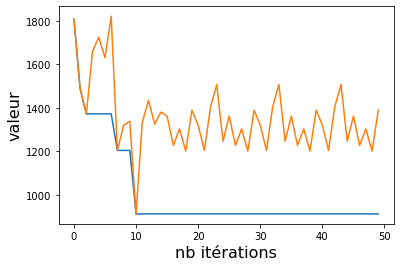

In [145]:
def tabu_search(initial_circuit, tabu_size, max_iteration, actual_roads):
    iteration = 1
    tabu_list = list()
    actual_circuit = copy.deepcopy(initial_circuit)

    best_actual_circuit = copy.deepcopy(initial_circuit)
    best_total_circuit = copy.deepcopy(initial_circuit)
    best_total_value = circuit_score(best_total_circuit, actual_roads)

    best_total_list = list()
    best_actual_list = list()

    while iteration <= max_iteration:
        iteration += 1
        best_actual_value = -1

        # on parcourt les voisins de la solution courante
        for neighbor in neighborhood(actual_circuit):
            if (len(tabu_list) == 0 or not np.any(np.all(neighbor == tabu_list, axis=1))) and (circuit_score(neighbor, actual_roads) <= best_actual_value or best_actual_value == -1):
                best_actual_value = circuit_score(neighbor, actual_roads)
                best_actual_circuit = copy.deepcopy(neighbor)

        # on met a jour la meilleur solution rencontree depuis le debut
        if best_actual_value < best_total_value:
            best_total_circuit = copy.deepcopy(best_actual_circuit)
            best_total_value = best_actual_value

        best_total_list.append(best_total_value)
        best_actual_list.append(best_actual_value)

        actual_circuit = copy.deepcopy(best_actual_circuit)

        if len(tabu_list) >= tabu_size: tabu_list.pop(0)
        tabu_list.append(copy.deepcopy(actual_circuit))

    return best_total_circuit, best_total_list, best_actual_list


test_circuit = np.array([20,18,2,32,37,44,48,52,70])


best_circuit, bt, ba= tabu_search(test_circuit, 9, 50, import_roads(copy.deepcopy(test_circuit)))
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
print(best_circuit)
res = plt.plot(range(50), bt)
res = plt.plot(range(50), ba)

## Multi-start

In [146]:
def tabu_multi_start(number, iteration, shuffled, actual_roads):
    best_local_score = -1
    best_local_circuit = []
    for i in range(0, number):
        shuffled_circuit = np.r_[0, shuffled, 0]

        bc, bt, ba= tabu_search(shuffled_circuit, 100, iteration, actual_roads)
        actual_score = circuit_score(bc, actual_roads)

        if best_local_score == -1 or actual_score < best_local_score:
            best_local_score = actual_score
            best_local_circuit = bc


        np.random.shuffle(shuffled)
    return best_local_circuit, best_local_score

## Graphe vers circuits

In [147]:
def create_circuits(clients_list, roads_list, k):
    total_of_clients = sum(len(client_list) for client_list in [num_clients_FR, num_clients_PA, num_clients_PR])
    number_of_clients = [len(client_list) for client_list in [num_clients_FR, num_clients_PA, num_clients_PR]]
    trucks_for_lists = [int(k * percentage) for percentage in [len(client_list) / total_of_clients for client_list in [num_clients_FR, num_clients_PA, num_clients_PR]]]
    while sum(trucks_for_lists) != k: trucks_for_lists[random.randint(0, len(trucks_for_lists) - 1)] += 1

    origins = [0,0,0]
    clients_per_k = [noc // tfl for noc, tfl in zip(number_of_clients, trucks_for_lists)]
    difference = [noc % cpk for noc, cpk in zip(number_of_clients, clients_per_k)]


    best_circuits = [[] for _ in range (len(clients_list))]

    for idx, client_list in enumerate(clients_list):
        passed = [origins[idx],]
        actual_node = random.choice(client_list)
        for truck in range(0, trucks_for_lists[idx]):

            truck_circuit = np.array([actual_node,])
            passed.append(actual_node)

            while len(truck_circuit) != clients_per_k[idx]:
                truck_circuit = np.r_[truck_circuit, get_closer_node(truck_circuit[-1], roads_list[idx], passed)]
                passed.append(truck_circuit[-1])

            if difference[idx] > 0:
                difference[idx] -= 1
                truck_circuit = np.r_[truck_circuit, get_closer_node(truck_circuit[-1], roads_list[idx], passed)]
                passed.append(truck_circuit[-1])

            if len(truck_circuit) % 6 == 0:
                actual_node = get_closer_node(truck_circuit[0], roads_list[idx], passed)
            else:
                actual_node = get_closer_node(truck_circuit[-1], roads_list[idx], passed)
            best_circuits[idx].append(truck_circuit)
    return best_circuits

## Glouton

In [148]:
def get_closer_node(node, roads, ignored):
    min_weight = -1
    next_node = 0
    roads = [r for r in roads if r["id_ville_1"] not in ignored or r["id_ville_2"] not in ignored]
    for road in roads:
        if road['est_oriente']:
            if (road['id_ville_1'] == node) and (min_weight == -1 or min_weight > road['poids_1']):
                min_weight = road['poids_1']
                next_node = road['id_ville_2']
            elif (road['id_ville_2'] == node) and (min_weight == -1 or min_weight > road['poids_2']):
                min_weight = road['poids_2']
                next_node = road['id_ville_1']
        elif (min_weight > road['poids'] or  min_weight == -1) and (road["id_ville_1"] == node or road["id_ville_2"] == node):
            min_weight = road['poids']
            next_node = road['id_ville_1'] if road["id_ville_2"] == node else road['id_ville_2']

    return next_node

## Tests

In [149]:
shuffled_circuit = np.array([5,4,6])
print(np.r_[0, shuffled_circuit, 0])
#circuits_per_type = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], [roads_FR, roads_PA, roads_PR], k)




[0 5 4 6 0]


0
[958 258  18 493 886 214 415 799 478 810]
(array([  0, 258, 958,  18, 493, 886, 214, 415, 799, 478, 810,   0]), 574)
[506 156 112 873 192 627 544 848 790 520]
(array([  0, 520, 156, 506, 790, 848, 544, 627, 192, 873, 112,   0]), 383)
[  1  79 262 308 176 127  87 702 290  84]
(array([  0,   1,  79, 262, 308, 176, 127,  87, 702, 290,  84,   0]), 344)
[463 188  53 287 829 522 842 839 252]
(array([  0, 463, 188, 252, 839, 842, 522, 829,  53, 287,   0]), 941)
[351 445 285  16  94 884   8 229 726]
(array([  0, 351, 445, 285, 884,   8, 229, 726,  16,  94,   0]), 519)
[452 806 787 563  69  68 384 561 734]
(array([  0, 563, 787, 806, 452,  69,  68, 384, 561, 734,   0]), 293)
[993 609 968 678 356 207  86 395  74]
(array([  0, 609, 968, 678, 356, 207,  86, 395,  74, 993,   0]), 280)
[132 598 436 569 556 363  99  14 305]
(array([  0, 363,  99,  14, 305, 556, 569, 436, 598, 132,   0]), 408)
[473 255 447 707 524 513 516 903 424]
(array([  0, 424, 903, 516, 513, 524, 707, 473, 255, 447,   0]), 582)

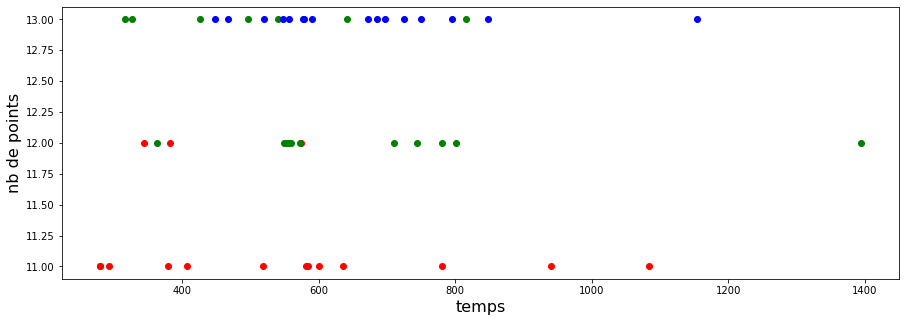

In [150]:
final = []
n = 6
it = 200
k = 50


start = time.perf_counter()

roads_all = [roads_FR, roads_PA, roads_PR]
circuits_per_type = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], roads_all, k)

colors = ['red', 'green', 'blue']

plt.figure(figsize=(15,5))
for i, circuits in enumerate(circuits_per_type):
    print(i)
    print("===================================================================================")
    for j, circuit in enumerate(circuits):
        print(circuit)
        final.append(tabu_multi_start(n, it, copy.deepcopy(circuit), import_roads(copy.deepcopy(circuit))))
        print(final[-1])
        plt.xlabel("temps", fontsize=16)
        plt.ylabel("nb de points", fontsize=16)
        plt.scatter(final[-1][1], len(final[-1][0]), color=colors[i],)

print(time.perf_counter() - start)
#print(final)